In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic

# to remove when funcsionalised
import numpy as np

#import h3.dataloading
import gtc_functions

In [3]:
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/'

## Weather Stations Data

In [4]:
# TODO: get this file on a consistent path
stations_metadata_csv_path = google_drive_personal_key + 'datasets/EFs/weather_data/isd-history.csv'

# date formats are specified
df_stations_all = pd.read_csv(stations_metadata_csv_path,parse_dates=['BEGIN','END'])
df_stations_all = gtc_functions.standardise_dfs(df_stations_all)
print(f'There are {len(df_stations_all)} records of weather stations globally.')

# remove rows with any key data missing
df_stations = df_stations_all.dropna(subset=['lat','lon','usaf','wban'])
print(f'{len(df_stations_all)-len(df_stations)} weather stations had key information missing so were removed.')

There are 29630 records of weather stations globally.
1187 weather stations had key information missing so were removed.


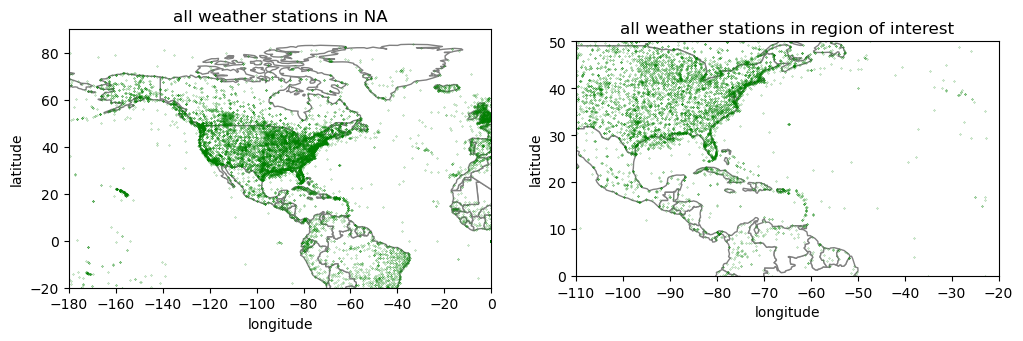

In [5]:
### PLOT WEATHER STATIONS
gdf_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))

# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

fig, ax = plt.subplots(1,2,figsize=[12,5]);

for i in range(len(fig.axes)):
    ax[i].set_xlabel('longitude'), ax[i].set_ylabel('latitude')
    world.plot(ax=ax[i],color='white',edgecolor='grey')
    gdf_stations.plot(ax=ax[i],color='green',markersize=0.05,alpha=0.8);

ax[0].set_xlim([-180,0]);
ax[0].set_ylim([-20,90]);
ax[0].set_title('all weather stations in NA');

ax[1].set_xlim([-110,-20]);
ax[1].set_ylim([0,50]);
ax[1].set_title('all weather stations in region of interest');

In [6]:
# approximate lat/lon ranges of interest
lat_range = [0,40]
lon_range = [-110,-50]

# stations dataframe limited to region of interest 
df_stations = gtc_functions.exclude_df_rows_by_range(df_stations_all,['lat','lon'],[lat_range,lon_range])
print('Number of stations within lat-lon range: ',len(df_stations))

Number of stations within lat-lon range:  3895


In [7]:
# generating filename of hourly weather data 
df_stations = gtc_functions.concat_df_cols(df_stations,'csv_filenames',['usaf','wban']);

# ensure standardised
gtc_functions.standardise_dfs(df_stations,date_cols=['begin','end'])

df_stations.head()

,usaf,wban,station_name,ctry,state,icao,lat,lon,elev(m),begin,end,geometry,csv_filenames
14511,690014,99999,C STN WHITE SANDS,US,NM,NaN,32.350,-106.367,1224.0,1987-01-01,1991-06-11,POINT (-106.367 32.35),69001499999
14517,690090,99999,HURLBURT FLD/EXERCIS,US,FL,NaN,30.433,-86.717,3.0,2008-10-10,2008-10-17,POINT (-86.717 30.433),69009099999
14528,690186,99999,SAN JOSE DEL GUAVIA,CO,NaN,KQB7,2.567,-72.633,184.0,2008-01-01,2008-06-23,POINT (-72.633 2.567),69018699999
14529,690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.433,-99.850,545.3,1943-12-01,1997-12-31,POINT (-99.85 32.433),69019013910
14530,690190,99999,DYESS AFB/ABILENE,US,TX,NaN,32.417,-99.850,545.0,2000-01-03,2004-12-30,POINT (-99.85 32.417),69019099999


In [8]:
# write processed stations file to pickle
df_stations_pkl_path_dir = google_drive_personal_key + 'datasets/EFs/weather_data'
df_stations_pkl_name = 'weather_stations'

gtc_functions.write_df_to_pkl(df_stations_pkl_path_dir,
                            df_stations_pkl_name,
                            df_stations)

File path already exists. No new file written to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/weather_stations.pkl.


## NOAA 6-Hourly Hurricane Data

In [9]:
# noaa 6-hourly
df_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_hurricanes.pkl'
df_noaa_weather = pd.read_pickle(df_noaa_pkl_path)

In [27]:
### Restrict NOAA data to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.return_most_recent_events_by_name(df_noaa_weather,xbd_hurricane_names)

In [11]:
# write to pkl
df_xbd_noaa_pkl_path_dir = google_drive_personal_key + '/datasets/EFs/weather_data'
df_xbd_noaa_pkl_name = 'noaa_xbd_hurricanes'

gtc_functions.write_df_to_pkl(df_xbd_noaa_pkl_path_dir,
                            df_xbd_noaa_pkl_name,
                            df_xbd_hurricanes_noaa)

File path already exists. No new file written to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC//datasets/EFs/weather_data/noaa_xbd_hurricanes.pkl.


## Hurricane track interpolation

In [29]:
df_xbd_hurricanes_noaa

# num_interpolation points TODO: make this proportional to the distance between observations
num_inter_points = 2
new_index = pd.RangeIndex(len(df_xbd_hurricanes_noaa)*(num_inter_points+1))
inter_df = pd.DataFrame(np.nan, index=new_index, columns=df_xbd_hurricanes_noaa.columns)	# limit to necessary columns?
ids = np.arange(len(df_xbd_hurricanes_noaa))*(num_inter_points+1)
inter_df.loc[ids] = df_xbd_hurricanes_noaa.values
inter_df.head()

,tag,name,num_entries,date,record_id,sys_status,lat,lon,max_sust_wind,min_p,...,r_se_50,r_nw_50,r_sw_50,r_ne_64,r_se_64,r_nw_64,r_sw_64,r_max_wind,strength,geometry
0,AL062018,FLORENCE,79.0,2018-09-18 12:00:00,,EX,42.2,-73.3,25.0,1006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,POINT (-73.3 42.2)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL062018,FLORENCE,79.0,2018-09-18 06:00:00,,EX,41.3,-76.8,25.0,1007.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,POINT (-76.8 41.3)
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Standardise xBD observation dataframe

In [ ]:
def standardise_xbd_obs_df(
	df: pd.DataFrame
) -> pd.DataFrame:
	"""Standardise df of xbd point observations. Renames 'disaster_name' column to 'name', and makes each disaster name
	standalone and capitalised e.g. 'FLORENCE' rather than 'hurricane-florence'
	"""

	df.rename({'disaster_name': 'name', inplace=True})

	# match naming convention with NOAA for ease of comparison later
	df['name'] = df['name'].apply(
    	lambda x: x.split('-')[-1]).str.upper()

	return gtc_functions.standardise_dfs(df,date_cols=['capture_date'])



In [12]:
df_xbd_points_path_dir = google_drive_personal_key + 'datasets/xBD_data/'
df_xbd_pkl_filename = 'df_points_posthurr.pkl'
df_xbd_points_path = '/'.join((df_xbd_points_path_dir,df_xbd_pkl_filename))

df_xbd_points = pd.read_pickle(df_xbd_points_path)



,geometry,damage_class,disaster_name,capture_date,lon,lat
0,POINT (-77.92443 34.78850),2,FLORENCE,2018-09-20 16:04:41+00:00,-77.924432,34.788502
1,POINT (-77.92459 34.78817),1,FLORENCE,2018-09-20 16:04:41+00:00,-77.924586,34.788174
2,POINT (-85.61007 30.20004),0,MICHAEL,2018-10-13 16:48:15+00:00,-85.610074,30.200042
3,POINT (-85.61057 30.20001),0,MICHAEL,2018-10-13 16:48:15+00:00,-85.610569,30.200012
4,POINT (-85.61055 30.20060),1,MICHAEL,2018-10-13 16:48:15+00:00,-85.610547,30.200601
...,...,...,...,...,...,...
23049,POINT (-77.91797 34.64623),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917967,34.646233
23050,POINT (-77.91773 34.64628),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917726,34.646278
23051,POINT (-77.91765 34.64650),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917652,34.646497
23052,POINT (-77.91835 34.64612),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.918351,34.646123


In [13]:
# TODO: common path
df_xbd_obs_pkl_name = 'xbd_points_posthurr_reformatted'

gtc_functions.write_df_to_pkl(df_xbd_points_path_dir,
                            df_xbd_obs_pkl_name,
                            df_xbd_points)    

File path already exists. No new file written to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/xBD_data//xbd_points_posthurr_reformatted.pkl.


# Get CMORPH Data List

In [14]:
# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.return_most_recent_events_by_name(df_xbd_hurricanes_noaa,xbd_hurricane_names)

In [15]:
urls = gtc_functions.generate_cmorph_urls(pd.Timedelta(7,'d'),pd.Timedelta(7,'d'),df_xbd_points,df_xbd_hurricanes_noaa)
len(urls)

1440

In [16]:
# generate textfile of urls for download
with open('CMORPH_urls.txt', 'w') as fl:
    for line in urls:
        fl.write(f"{line}\n")